# FrequencySeries の新機能と高度な操作

このノートブックでは、`gwexpy` で拡張された `FrequencySeries` クラスの新しいメソッドと機能について紹介します。
主に複素スペクトルの扱い、微積分、フィルタリング（スムージング）、および他ライブラリとの連携機能に焦点を当てます。

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from gwexpy.frequencyseries import FrequencySeries
from gwexpy.plot import Plot
import astropy.units as u

plt.rcParams['figure.figsize'] = (10, 6)

## 1. データの準備

まずは `TimeSeries` から FFT を用いて `FrequencySeries` を作成します。
ここでは、特定の周波数成分を持つテスト信号を生成します。

TimeSeries([-0.3104177 ,  0.09541665,  0.25086034, ...,
             1.18045557,  0.69069643,  0.3977245 ]
           unit: um,
           t0: 0.0 s,
           dt: 0.0009765625 s,
           name: Test Signal,
           channel: None)
Type: <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
Length: 3073
df: 0.16666666666666666 Hz


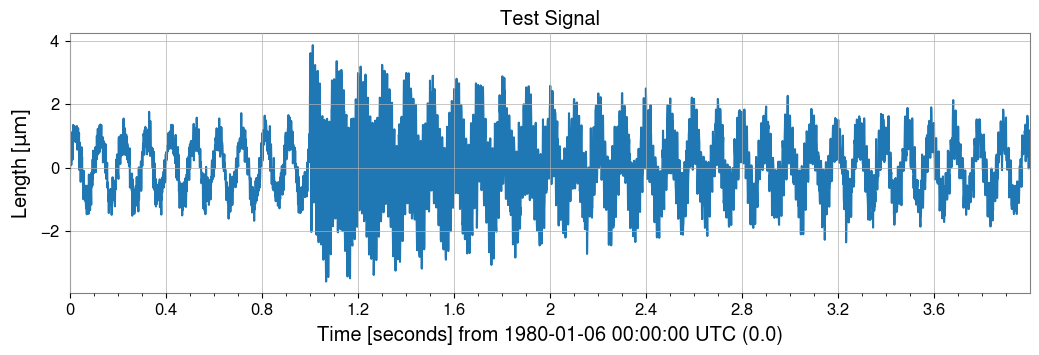

In [2]:
fs = 1024
t = np.arange(0, 4, 1/fs)
exp = np.exp(-t/1.5)
exp[:int(exp.size/4)]=0
data = np.sin(2 * np.pi * 10.1 * t) + 5*exp * np.sin(2 * np.pi * 100.1 * t) + np.random.normal(scale=0.3, size=len(t))
ts = TimeSeries(data, dt=1/fs, unit='um', name='Test Signal')
print(ts)
ts.plot(title=ts.name)

# FFT を実行して FrequencySeries を取得 (transient モードを使用してパディングを適用)
spec = ts.fft(mode="transient", pad_left=1.0, pad_right=1.0, nfft_mode="next_fast_len")
print(f"Type: {type(spec)}")
print(f"Length: {len(spec)}")
print(f"df: {spec.df}")

## 2. 複素スペクトルの可視化と変換

### 位相と振幅
`phase()`, `degree()`, `to_db()` メソッドを使用すると、複素スペクトルを直感的な単位に変換できます。

/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


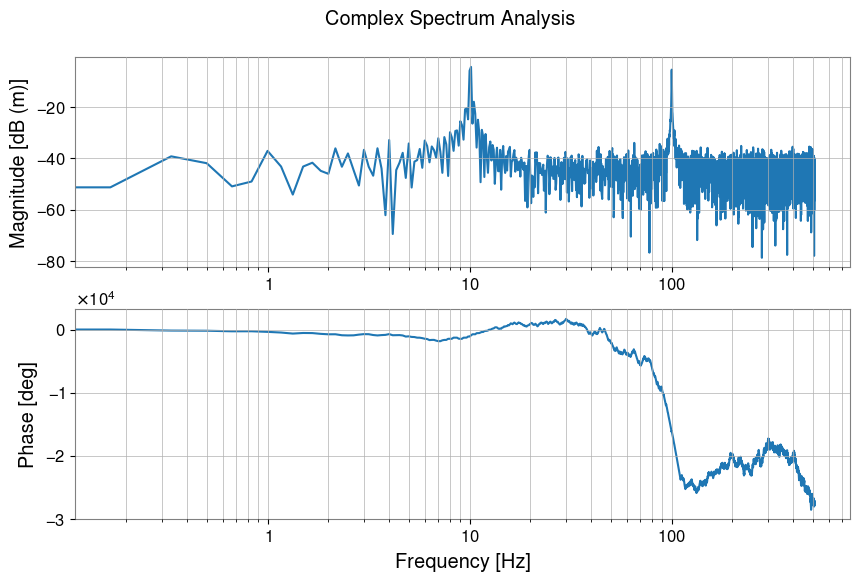

In [3]:
# 振幅を dB に変換 (ref=1.0, 20*log10)
spec_db = spec.to_db()

# 位相を取得 (度数表記、unwrap=True で連続化)
spec_phase = spec.degree(unwrap=True)

plot = Plot(spec_db, spec_phase, separate=True, sharex=True, xscale='log')
ax = plot.axes
ax[0].set_ylabel('Magnitude [dB (m)]')
ax[0].grid(True, which='both')

ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which='both')
plot.figure.suptitle('Complex Spectrum Analysis')
plot.show()

## 3. 周波数ドメインでの微積分

`differentiate_time()` および `integrate_time()` メソッドにより、周波数ドメインで微分・積分を行うことができます。
これは「変位・速度・加速度」の変換（$(2 \pi i f)^n$ の乗算）を簡単に行うための機能です。

/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


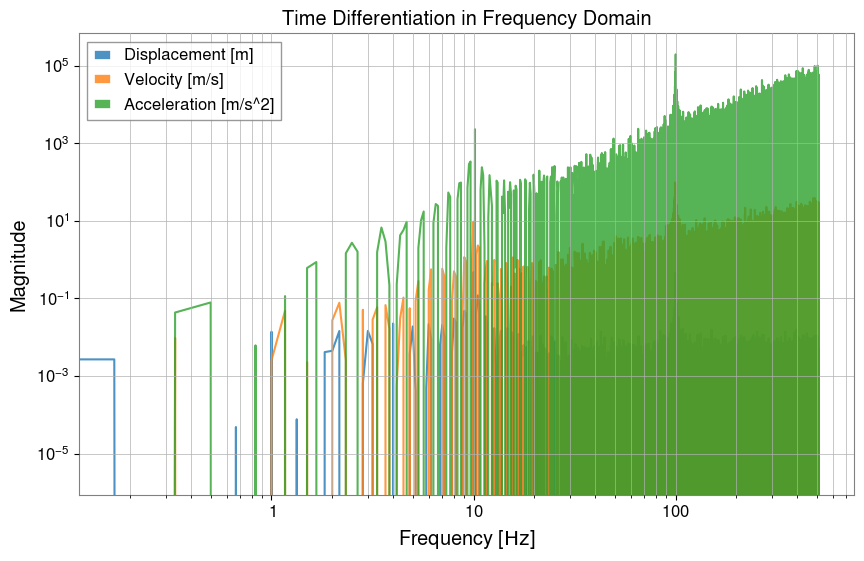

In [4]:
# 変位 (m) -> 速度 (m/s) に微分
vel_spec = spec.differentiate_time()

# 変位 (m) -> 加速度 (m/s^2) に 2回微分
accel_spec = vel_spec.differentiate_time()

plot = Plot(spec, vel_spec, accel_spec, xscale='log', yscale='log',alpha=0.8)
ax = plot.gca()
ax.get_lines()[0].set_label('Displacement [m]')
ax.get_lines()[1].set_label('Velocity [m/s]')
ax.get_lines()[2].set_label('Acceleration [m/s^2]')
ax.legend()
ax.grid(True, which='both')
ax.set_title('Time Differentiation in Frequency Domain')
ax.set_ylabel('Magnitude')
plot.show()

## 4. スペクトルのスムージングとピーク検出

### スムージング
`smooth()` メソッドを使用すると、移動平均などによるスペクトルの平滑化が可能です。

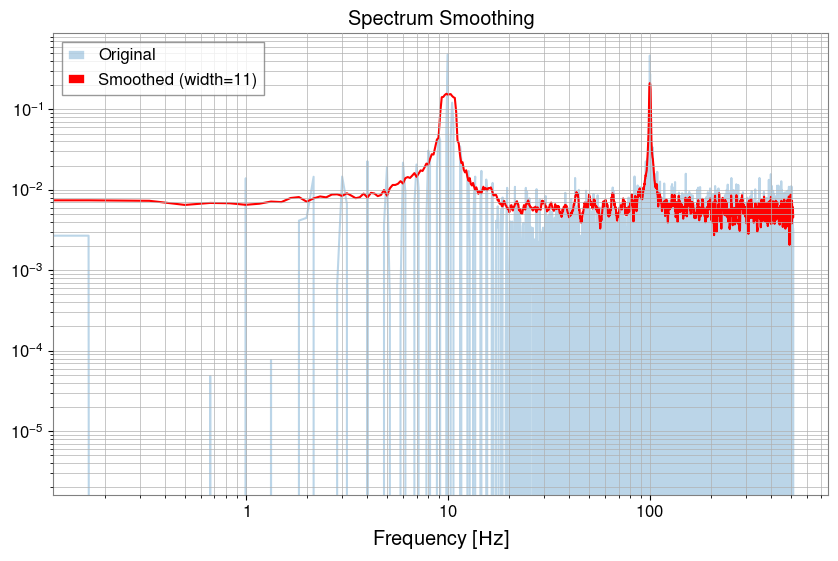

In [5]:
# 振幅ドメインで 11 サンプルのスムージング
spec_smooth = spec.smooth(width=11)

plot = Plot(spec, spec_smooth, xscale='log', yscale='log')
ax = plot.gca()
ax.get_lines()[0].set_label('Original')
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label('Smoothed (width=11)')
ax.get_lines()[1].set_color('red')
ax.legend()
ax.grid(True, which='both')
ax.set_title('Spectrum Smoothing')
plot.show()

### ピーク検出
`find_peaks()` メソッドは `scipy.signal.find_peaks` をラップしており、特定の閾値を超えるピークを簡単に抽出できます。

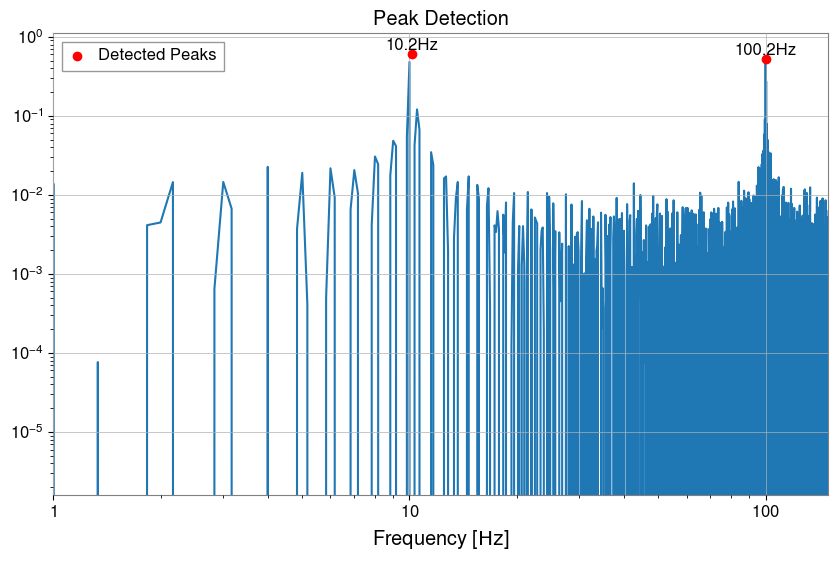

In [6]:
# 振幅 0.2 以上のピークを探す
peak_indices, props = spec.find_peaks(threshold=0.2)

peak_freqs = spec.frequencies[peak_indices]
peak_values = np.abs(spec[peak_indices])

plot = Plot(spec)
ax = plot.gca()
ax.scatter(peak_freqs, peak_values, color='red', zorder=3, label='Detected Peaks')
for f, v in zip(peak_freqs.value, peak_values.value):
    ax.text(f, v, f"{f:.1f}Hz", ha='center', va='bottom')

ax.set_xlim(1, 150)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Peak Detection')
ax.legend()
plot.show()

## 5. 高度な解析機能

### 群遅延 (Group Delay)
`group_delay()` メソッドは、位相の周波数微分から群遅延（信号のエンベロープの遅延）を計算します。

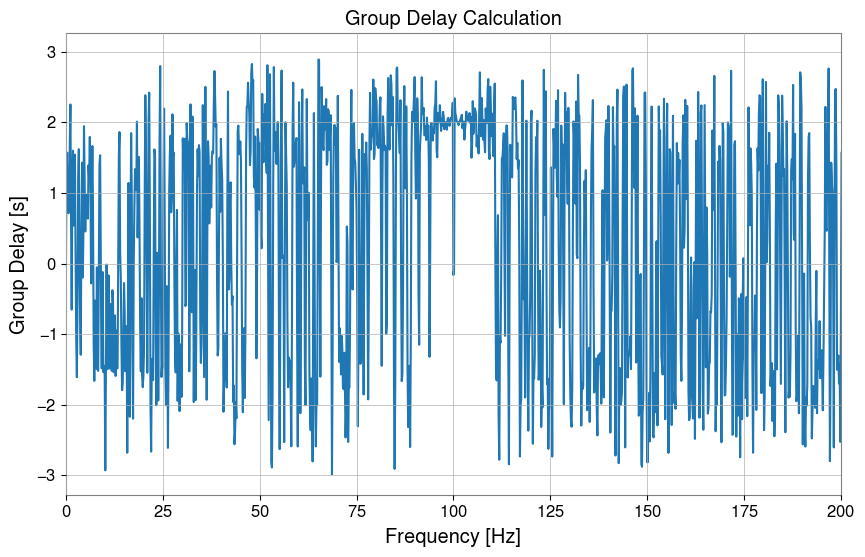

In [7]:
gd = spec.group_delay()

plot = Plot(gd)
ax = plot.gca()
ax.set_ylabel('Group Delay [s]')
ax.set_xlabel('Frequency [Hz]')
ax.set_xlim(0, 200)
ax.set_title('Group Delay Calculation')
plot.show()

### 逆FFT (ifft)
`ifft()` メソッドは、`TimeSeries` を返します。`mode="transient"` で FFT した結果であっても、情報を引き継いで元の長さに戻す (trim=True) などの制御が可能です。

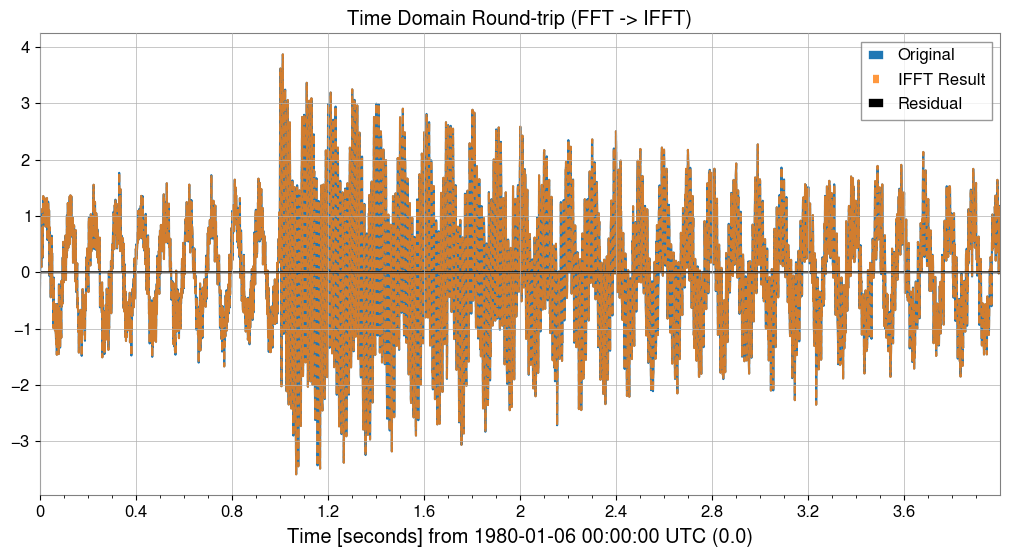

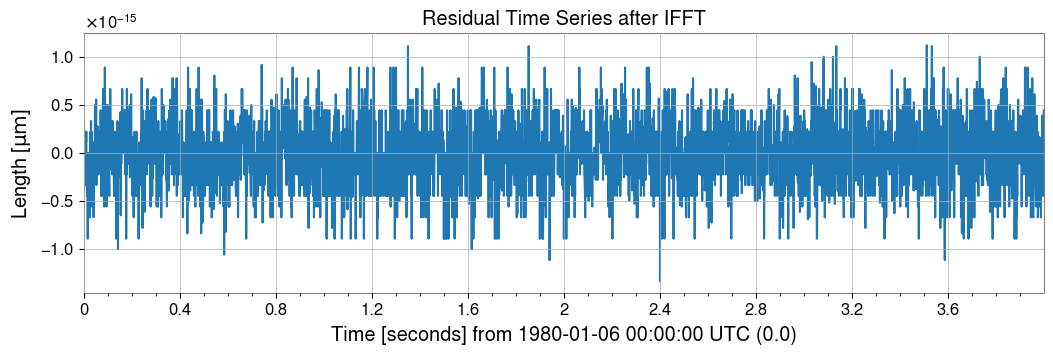

In [8]:
# 逆 FFT で TimeSeries に戻す
# mode="auto" は、入力 FrequencySeries が持つ transient 情報を読み取って適切に処理します
inv_ts = spec.ifft(mode="auto")
red_ts = inv_ts - ts

plot = Plot(ts, inv_ts, red_ts)
ax = plot.gca()
ax.get_lines()[0].set_label('Original')
ax.get_lines()[1].set_label('IFFT Result')
ax.get_lines()[2].set_label('Residual')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[1].set_alpha(0.8)
ax.get_lines()[2].set_color('black')
ax.legend()
ax.set_title('Time Domain Round-trip (FFT -> IFFT)')
plot.show()

red_ts.plot(title='Residual Time Series after IFFT');

## 6. 他ライブラリとの連携

Pandas, xarray, control ライブラリとの相互変換が追加されています。

In [9]:
# Pandas Series へ変換
pd_series = spec.to_pandas()
print("Pandas index sample:", pd_series.index[:5])
display(pd_series)

# xarray DataArray へ変換
da = spec.to_xarray()
print("xarray coord name:", list(da.coords))
display(da)

# control.FRD へ変換 (制御系の解析に使用可能)
try:
    from control import FRD
    frd_obj = spec.to_control_frd()
    print("Successfully converted to control.FRD")
    display(frd_obj)
except ImportError:
    print("python-control library not installed")

Pandas index sample: Index([0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666], dtype='float64', name='frequency')


frequency
0.000000      0.008906+0.000000j
0.166667      0.002688+0.000381j
0.333333     -0.009906-0.004543j
0.500000     -0.008007+0.000093j
0.666667      0.000048+0.002834j
                     ...        
511.333333    0.002939+0.006696j
511.500000    0.001683-0.000752j
511.666667    0.003328+0.000146j
511.833333   -0.005411-0.002952j
512.000000    0.003063+0.000000j
Name: Test Signal, Length: 3073, dtype: complex128

xarray coord name: ['frequency']


<xarray.DataArray 'Test Signal' (frequency: 3073)> Size: 49kB
array([ 0.00890647+0.j        ,  0.00268784+0.00038134j,
       -0.00990631-0.00454309j, ...,  0.00332849+0.00014642j,
       -0.00541103-0.00295245j,  0.00306251+0.j        ],
      shape=(3073,))
Coordinates:
  * frequency  (frequency) float64 25kB 0.0 0.1667 0.3333 ... 511.7 511.8 512.0
Attributes:
    unit:     um
    channel:  None
    epoch:    0.0

Successfully converted to control.FRD


FrequencyResponseData(
array([[[ 0.00890647+0.j        ,  0.00268784+0.00038134j,
         -0.00990631-0.00454309j, ...,
          0.00332849+0.00014642j, -0.00541103-0.00295245j,
          0.00306251+0.j        ]]], shape=(1, 1, 3073)),
array([0.00000000e+00, 1.66666667e-01, 3.33333333e-01, ...,
       5.11666667e+02, 5.11833333e+02, 5.12000000e+02],
      shape=(3073,)),
outputs=1, inputs=1)

## 7. 位相と群遅延の解析 (Phase & Group Delay)

`FrequencySeries` クラスには、位相 (`phase`, `angle`) や群遅延 (`group_delay`) を計算する便利なメソッドが追加されています。

In [10]:
# 単一チャンネルを取り出す
fs = spec

# 位相の計算 (ラジアン)
phi = fs.phase(unwrap=True)
print("\nUnwrapped Phase (rad) at 10Hz:", phi.value[10])

# 位相の計算 (度)
deg = fs.degree(unwrap=True)
print("Unwrapped Phase (deg) at 10Hz:", deg.value[10])

# 群遅延 (Group Delay) の計算
# Group Delay = -d(phi)/d(omega)
gd = fs.group_delay()
print("\nGroup Delay (s) at 10Hz:", gd.value[10])


Unwrapped Phase (rad) at 10Hz: -9.669871299223816
Unwrapped Phase (deg) at 10Hz: -554.0428138802107

Group Delay (s) at 10Hz: 1.155690044448237


## 8. Python Control Library との連携

制御工学の分野で標準的な `control` ライブラリの **Frequency Response Data (FRD)** オブジェクトと相互変換が可能です。
これにより、GWExPyで計測した伝達関数を、制御系の設計や解析に直接利用できます。


--- Converted to Control FRD ---
<FrequencyResponseData>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

Freq [rad/s]  Response
------------  ---------------------
       0.000    0.008906        +0j
       0.167    0.002688+0.0003813j
       0.333   -0.009906 -0.004543j
       0.500   -0.008007+9.314e-05j
       0.667   4.836e-05 +0.002834j
       0.833  -0.0002256 +0.003518j
       1.000     0.01391-0.0004025j
       1.167   -0.002146 -0.006559j
       1.333   7.663e-05 +0.001963j
       1.500   -0.006889-0.0002412j
       1.667   -0.007941 +0.001986j
       1.833    0.004139 +0.003904j
       2.000    0.004478 -0.002174j
       2.167     0.01451 -0.005693j
       2.333   -0.006836-0.0001731j
       2.500     -0.0111 +0.005574j
       2.667   -0.005754 +0.001135j
       2.833   0.0006491 -0.002873j
       3.000     0.01459+0.0004877j
       3.167    0.006697 -0.001433j
       3.333   -0.003585  -0.00284j
       3.500      -0.014 +0.007002j
       3.667   -0.005557 -0.002933j
   

/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/control/frdata.py:427: FutureWarning: fresp attribute is deprecated; use frdata
  warn("fresp attribute is deprecated; use frdata", FutureWarning)



--- Restored FrequencySeries ---
FrequencySeries([ 0.00890647+0.j        ,
                  0.00268784+0.00038134j,
                 -0.00990631-0.00454309j, ...,
                  0.00332849+0.00014642j,
                 -0.00541103-0.00295245j,
                  0.00306251+0.j        ]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.02652582384864922 Hz,
                epoch: None,
                name: None,
                channel: None)


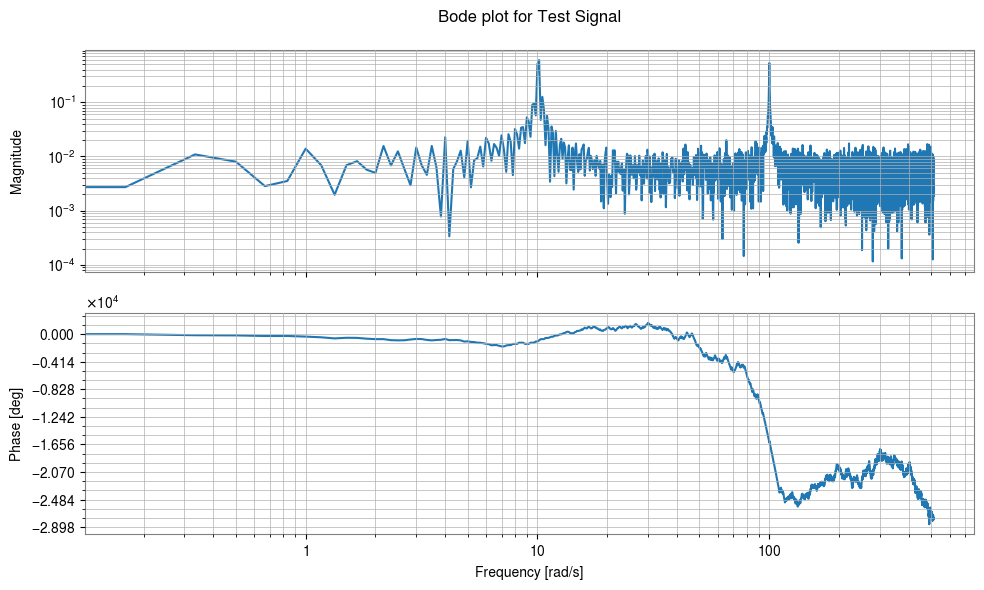

In [11]:
try:
    import control
    
    # FrequencySeries -> control.FRD 変換
    # frequency_unit="Hz" を指定すると、内部で rad/s に適切に変換して渡します
    frd_sys = fs.to_control_frd(frequency_unit="Hz")
    
    print("\n--- Converted to Control FRD ---")
    print(frd_sys)
    
    # ボード線図のプロット (controlライブラリの機能)
    control.bode(frd_sys) # (プロット環境があれば実行可能)
    
    # control.FRD -> FrequencySeries 復元
    fs_restored = FrequencySeries.from_control_frd(frd_sys, frequency_unit="Hz")
    
    print("\n--- Restored FrequencySeries ---")
    print(fs_restored)
    
except ImportError:
    print("Python Control Systems Library is not installed.")

## 9. 求積和 (Quadrature Sum)

直交位相の和を計算する機能です。

Noise A: 1.0, Noise B: 2.0
Total (Sqrt Sum): 2.23606797749979


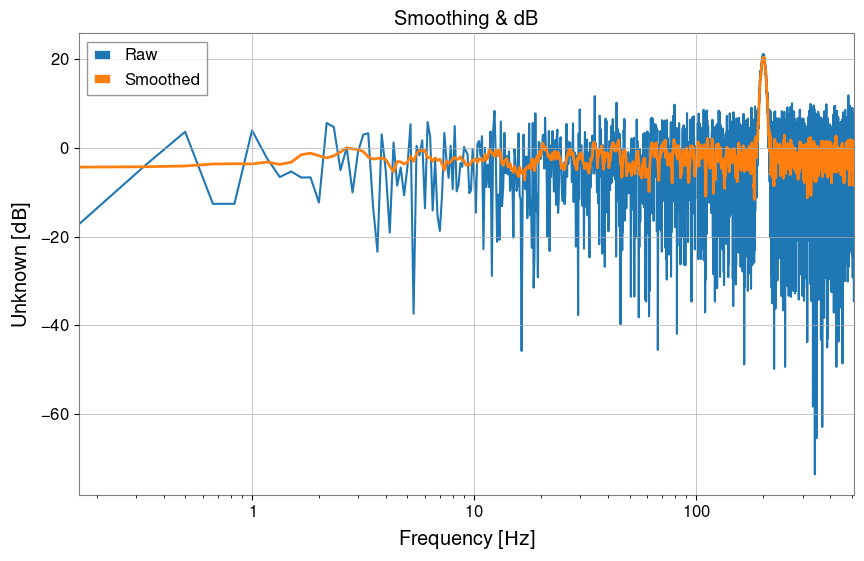

In [12]:
# Generate noisy data
np.random.seed(42)
f = spec.frequencies.value
noise = np.abs(np.random.randn(f.size))
peak = 10.0 * np.exp(-(f - 200)**2 / 50.0)
data = noise + peak

raw = FrequencySeries(data, frequencies=f, unit='V', name='Raw Data')

# Smooth
smoothed = raw.smooth(width=10, method='amplitude')
smoothed.name = 'Smoothed'

# Convert to dB
raw_db = raw.to_db()
smoothed_db = smoothed.to_db()
raw_db.name = 'Raw (dB)'
smoothed_db.name = 'Smoothed (dB)'

plot = raw_db.plot(label='Raw', title="Smoothing & dB")
ax = plot.gca()
ax.plot(smoothed_db.frequencies, smoothed_db.value, label='Smoothed', linewidth=2)
ax.legend()
plot.show()

# Quadrature Sum (Noise Budget example)
noise_a = FrequencySeries(np.ones_like(f), frequencies=f, unit='V', name='Noise A')
noise_b = FrequencySeries(np.ones_like(f) * 2, frequencies=f, unit='V', name='Noise B')

total = noise_a.quadrature_sum(noise_b)
print(f"Noise A: {noise_a.value[0]}, Noise B: {noise_b.value[0]}")
print(f"Total (Sqrt Sum): {total.value[0]}")